In [85]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# YOU WILL NEED TO AUTHORISE ON KAGGLE USING PERSONAL TOKEN.
import kagglehub
kagglehub.login()


In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load data and combine. Check for missing values.

In [100]:
titanic_path = kagglehub.competition_download('titanic') # Downloading the dataset
# Use os.path.join to construct file paths
train_csv_path = os.path.join(titanic_path, 'train.csv')
test_csv_path = os.path.join(titanic_path, 'test.csv')


# Use the new paths to read the CSV files.
df_train = pd.read_csv(train_csv_path)
df_train.columns = map(str.lower, df_train.columns)
print('Train dataset has entries:', len(df_train))
# 890 is the last index associated with train dataset


# Use the new paths to read the CSV files.
df_test = pd.read_csv(test_csv_path)
df_test.columns = map(str.lower, df_test.columns)
print('Train dataset has entries:', len(df_test))

frames = [df_train,df_test]
combined = pd.concat(frames)
combined.reset_index(drop=True, inplace=True)
print('Combined dataset has entries:', len(combined))

print('Combined dataset columns are:', combined.columns.tolist())

Train dataset has entries: 891
Train dataset has entries: 418
Combined dataset has entries: 1309
Combined dataset columns are: ['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']


In [101]:
print(combined.isnull().sum())

passengerid       0
survived        418
pclass            0
name              0
sex               0
age             263
sibsp             0
parch             0
ticket            0
fare              1
cabin          1014
embarked          2
dtype: int64


There are a few missing values in the dataset for age, fare, cabin, and embarked.

## Exploratory data analysis.

I iterate over the variables to analyse them, their relationship with the variable of interest (ie survived). I also deal with missing data if needed and generate new variables.

### EDA: passegerid.

In [102]:
print('Unique IDs are:', combined['passengerid'].unique())
print('The number of unique passenger IDs in combined dataset:', len(combined['passengerid'].unique()))

Unique IDs are: [   1    2    3 ... 1307 1308 1309]
The number of unique passenger IDs in combined dataset: 1309


In [103]:
for df in [df_train, df_test]:
    df.drop(['passengerid'], axis=1, inplace=True)

Passenger ID seems uninformative. They simply run from 1 to 1309, all unique. There are no missing values or duplicates. Drop the variable.

### EDA: pclass.
Hypothesis: rich passenger had higher survival chances.

In [104]:
for i in df_train['pclass'].unique():
    pclass = df_train.loc[df_train.pclass == i]["survived"]
    rate = sum(pclass)/len(pclass)
    print("% of", i, "class who survived:", round(rate,2))
    if i == min(df_train['pclass'].unique()):
        largest = rate
    elif i == max(df_train['pclass'].unique()):
        smallest = rate

print("Survivability difference between first and third class", round(largest-smallest,2))

% of 3 class who survived: 0.24
% of 1 class who survived: 0.63
% of 2 class who survived: 0.47
Survivability difference between first and third class 0.39


Initial hypothesis confirmed: passengers from first class had 39ppts higher chances of survival relative to third class. Survivabulity in the second class was interdemiate.

### EDA: name.

In [105]:
print(combined['name'].unique())
print('The number of unique names in combined dataset:', len(combined['name'].unique()))

['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' ... 'Saether, Mr. Simon Sivertsen'
 'Ware, Mr. Frederick' 'Peter, Master. Michael J']
The number of unique names in combined dataset: 1307


In [106]:
duplicates = combined[combined.duplicated(subset=['name'], keep=False)]  # keep=False to show all duplicates
print(duplicates)

     passengerid  survived  pclass                  name     sex   age  sibsp  \
289          290       1.0       3  Connolly, Miss. Kate  female  22.0      0   
696          697       0.0       3      Kelly, Mr. James    male  44.0      0   
891          892       NaN       3      Kelly, Mr. James    male  34.5      0   
897          898       NaN       3  Connolly, Miss. Kate  female  30.0      0   

     parch  ticket    fare cabin embarked  
289      0  370373  7.7500   NaN        Q  
696      0  363592  8.0500   NaN        S  
891      0  330911  7.8292   NaN        Q  
897      0  330972  7.6292   NaN        Q  


There are two duplicates in the data. Checking online, Mr Kelly James apprears to be passenger ID 696 (ticket number coincides). Miss Kate Connolly is passenger ID 897 (ticket number coincides). Checking the other two tickets, 370373 belonged to Miss Catherine Connoly, who survived, and 330911 was of James Kelly who also died. So these are different people. We keep everything as is.

Interestingly, the names data has various titles. We can extract these titles and try to group them meaningfully.

In [107]:
titles = []
for name in combined['name']:
    title = name.split(',')[1].split('.')[0].strip()
    if title not in titles:
        titles.append(title)

print(titles)

title_dict = {
    'Sir': 'noble', 'Major': 'army', 'the Countess': 'noble',
    'Don': 'noble', 'Mlle': 'ms', 'Capt': 'army',
    'Dr': 'other', 'Lady': 'noble', 'Rev': 'other',
    'Mrs': 'mrs', 'Jonkheer': 'noble', 'Master': 'master',
    'Ms': 'ms', 'Mr': 'mr', 'Mme': 'mrs',
    'Miss': 'ms', 'Col': 'army',
    'Dona': 'noble'
}


['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']


there are some specific unique titles indicating army rank or noble background. Also some standard titles are clearly French. We can batch titles into: Mrs, Ms, Mr, Noble, Army, Master (young boy in English), and Other (for Doctor and Reverand). Now, extract titles for the datasets, save as new variable, drop names.

In [108]:
def get_titles():
    dataset['title'] = dataset['name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    dataset['title'] = dataset.title.map(title_dict)

    return dataset

df = [df_train, df_test]
for dataset in df:
    dataset = get_titles()
    dataset = dataset.drop('name', axis=1, inplace=True)

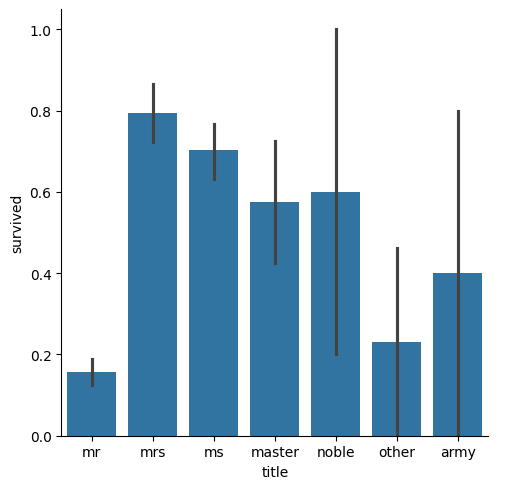

In [109]:
axes = sns.catplot(data=df_train, x='title', y='survived', kind="bar")

Passengers with the following titles [Mrs, Ms, Master, Noble] had higher chances of survival. This is sensible --these are females, children, and rich people .

### EDA: - sex.
Hypothesis: sex should be an important factor. Females should be given priority during evacuation.

In [110]:
women = df_train.loc[df_train.sex == 'female']["survived"]
rate_women = sum(women)/len(women)
print("% of women who survived:", round(rate_women,2))

men = df_train.loc[df_train.sex != 'female']["survived"]
rate_men = sum(men)/len(men)
print("% of men who survived:", round(rate_men,2))

print("Survivability difference between females and males", round(rate_women-rate_men,2))

% of women who survived: 0.74
% of men who survived: 0.19
Survivability difference between females and males 0.55


Indeed, females had 55ppts higher survivability chance than males.

### EDA: age.
263 records for age are missing in the combined dataset. Let's impute based on median values for cross-categories sex and title. This should capture some of the essential aspects of the data. For example, Master is clearly a boy, not a man. On the other hand, Dr can be both a man and a woman but clearly adult.


In [116]:
def impute_age(x):
    return x['age'].fillna(x['age'].median())

for df in [df_train, df_test]:
    df['age'] = df.groupby(['sex', 'title']).apply(impute_age).reset_index(level=[0,1], drop=True)

Empty DataFrame
Columns: [survived, pclass, sex, age, sibsp, parch, ticket, fare, cabin, embarked, title]
Index: []
Empty DataFrame
Columns: [pclass, sex, age, sibsp, parch, ticket, fare, cabin, embarked, title]
Index: []


<ipython-input-116-235c2805b3bd>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['age'] = df.groupby(['sex', 'title']).apply(impute_age).reset_index(level=[0,1], drop=True)
<ipython-input-116-235c2805b3bd>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['age'] = df.groupby(['sex', 'title']).apply(impute_age).reset_index(level=[0,1], drop=True)


Inintial hypothesis: age should be correlated with survivability as children should be given priority during evacuation.

In [117]:
print('Correlation between age and survivability:', df_train['age'].corr(df_train['survived']))

df = [df_train, df_test]
for dataset in df:
    dataset['minor'] = 0
    for index,row in dataset.iterrows():
        if dataset.loc[index, 'age'] < 16:
            dataset.loc[index, 'minor'] = 1

youth = df_train.loc[df_train.minor == 1]["survived"]
rate_youth = sum(youth)/len(youth)
print("% of minors who survived:", round(rate_youth,2))

non_youth = df_train.loc[df_train.minor != 1]["survived"]
rate_non_youth = sum(non_youth)/len(non_youth)
print("% of non-minors who survived:", round(rate_non_youth,2))

print("Survivability difference between minors and non-minors", round(rate_youth-rate_non_youth,2))

Correlation between age and survivability: -0.07866866515159471
% of minors who survived: 0.59
% of non-minors who survived: 0.36
Survivability difference between minors and non-minors 0.22


Survivability is meaningfully well correlated with age. However, discretising the dataset by minor (ie under 16) and older, the difference in survivabiltiy is 23ppts.

### EDA: sibsp and  parch.
Hypothesis: travelling with more people may have an effect on survivability. Perhaps it is nonlinear, as having some relatives on board is good but too many is probably problematic (think of a man with wife and 5 children).

People travelled with various number of relatives: [ 1  0  4  2  6  5  3  7 10]


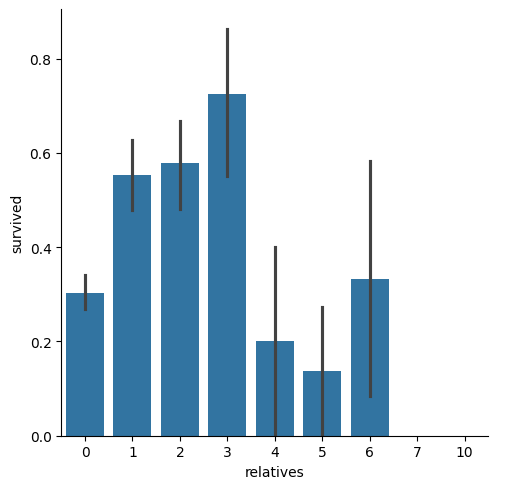

In [118]:
df = [df_train, df_test]
for dataset in df:
    dataset['relatives'] = dataset['sibsp'] + dataset['parch']

print('People travelled with various number of relatives:', df_train['relatives'].unique())

axes = sns.catplot(data=df_train, x='relatives', y='survived', kind="bar")

Travelling alone or with more than 3 relatives is associated with lower survivability. Let's generate relevant dummy variables: solo, small_family & large_family.

In [119]:
df = [df_train, df_test]
for dataset in df:
    dataset['relatives'] = dataset['sibsp'] + dataset['parch']

    dataset.loc[dataset['relatives'] > 0, 'solo']   = 0
    dataset.loc[dataset['relatives'] == 0, 'solo']  = 1

    dataset.loc[dataset['relatives'] <= 3, 'large_family'] = 0
    dataset.loc[dataset['relatives'] > 3, 'large_family'] = 1

    dataset.loc[(dataset['relatives'] > 0) & (dataset['relatives'] <= 3), 'small_family']   = 1
    dataset.loc[(dataset['relatives'] == 0) | (dataset['relatives'] > 3), 'small_family'] = 0


    dataset.drop(['sibsp','parch'], axis=1, inplace=True)

### EDA: ticket


In [120]:
print('The number of unique tickets in combined dataset:', len(combined['ticket'].unique()))

The number of unique tickets in combined dataset: 929


In [121]:
duplicates = combined[combined.duplicated(subset=['ticket'], keep=False)]  # keep=False to show all duplicates
print(len(duplicates))

596


In [122]:
for df in [df_train, df_test]:
    df.drop(['ticket'], axis=1, inplace=True)

There seem to be many duplicate tickets. I suppose this is for families travelling together. Ignore this column.

### EDA: fare.

In [123]:
missing_fare = combined[combined['fare'].isnull()]
print(missing_fare)

      passengerid  survived  pclass                name   sex   age  sibsp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      parch ticket  fare cabin embarked  
1043      0   3701   NaN   NaN        S  


There is a missing fare value for a ticket in third class with port of embarkment S. Impute at mean ticket value for this class and port.

In [125]:
def replace_zero_fare(row):
    if row['fare'] == 0 or pd.isna(row['fare']):
        return round(mean_fares.loc[(row['embarked'], row['pclass'])],4)
    else:
        return row['fare']

mean_fares = combined.groupby(['embarked', 'pclass'])['fare'].mean()
# print(mean_fares)

for df in [df_train, df_test]:
    df['fare'] = df.apply(replace_zero_fare, axis=1)

Initial hypothesis: higher fare is associated with higher pclass and higher survivability.

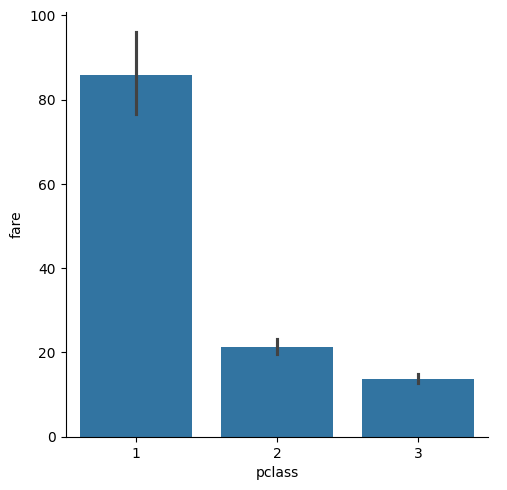

In [126]:
axes = sns.catplot(data=df_train, x='pclass', y='fare', kind="bar")

In [127]:
print('Correlation between fare and survivability:', df_train['fare'].corr(df_train['survived']))

Correlation between fare and survivability: 0.24857912847749122


ADD ME

### EDA: cabin

There is a lot of missing information in the Cabin variable. For now, giving the amount of missing data and likely correlation with pclass and fare, it makes sense to drop this variable. However, I can try imputing based on pclass and fare. This is work in process, the code is commented out.

In [128]:
for df in [df_train, df_test]:
    df.drop(['cabin'], axis=1, inplace=True)

In [ ]:
# print(combined['cabin'].value_counts(dropna=False))

# for df in [df_train, df_test]:
#     df['cabin_code'] = df['cabin'].str[0]
#     # print(df['cabin_code'].value_counts(dropna=False))

#     for cabin in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']:
#         incabin = df[df['cabin_code'] == cabin]
#         print(cabin, 'min', min(incabin['fare'].values), 'max', max(incabin['fare'].values))

In [ ]:
# axes = sns.catplot(data=df_train, x='cabin_code', y='fare', kind="bar")

In [ ]:
# for df in [df_train, df_test]:
#     for index,row in df.iterrows():
#         if (str(df.loc[index, 'cabin']) == "nan") & (df.loc[index, 'fare'] > 120):
#             df.loc[index, 'cabin'] = 'B'
#         elif (str(df.loc[index, 'cabin']) == "nan") & (df.loc[index, 'fare'] > 75):
#             guess = random.choice(['B', 'C'])
#             print(df.loc[index, 'fare'])
#         elif (str(df.loc[index, 'cabin']) == "nan") & (df.loc[index, 'fare'] < 20):
#             df.loc[index, 'cabin'] = 'G'


### EDA: port of embarkment.
Thre is a missing value here. Impute on mode (which is S).

In [129]:
missing_port = combined[combined['embarked'].isnull()]
print(missing_port)

print(combined['embarked'].value_counts(dropna=False))

     passengerid  survived  pclass                                       name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        sex   age  sibsp  parch  ticket  fare cabin embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  
embarked
S      914
C      270
Q      123
NaN      2
Name: count, dtype: int64


In [130]:
for df in [df_train, df_test]:
    print(df['embarked'].value_counts(dropna=False))
    df['embarked'] = df['embarked'].fillna('S')

embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
embarked
S    270
C    102
Q     46
Name: count, dtype: int64


Hypothesis: There could be some difference in survivabiltiy based on port of embarkment. This could be to do with the order in which cabins are filled and their proximity to evacuation equipment.

In [131]:
for port in ['S', 'C', 'Q']:
  embarked = df_train.loc[df_train.embarked == port]["survived"]
  rate_emb = sum(embarked)/len(embarked)
  print("% of passengers who embarked from ", port, " who survived:", round(rate_emb,2))

% of passengers who embarked from  S  who survived: 0.34
% of passengers who embarked from  C  who survived: 0.55
% of passengers who embarked from  Q  who survived: 0.39


Turns out, those who embarked from port C survived 21ppts more often than those who embarked from port S.

## Training models
I evaluate the performance of several machine learning models:
1. Logistic Regression
2. Random Forest
3. Decision Tree
4. K-Nearest Neighbors
5. Naive Bayes

to predict a binary outcome ('survived').

To ensure robust evaluation, I utilize a bootstrap method, creating multiple train/validation splits and assessing performance on each. This involves training each model on bootstrapped samples and evaluating their predictive accuracy on held-out validation sets.  

Key metrics I consider include:
1. accuracy
2. precision
3. recall
4. F1-score
5. ROC-AUC.  

Furthermore, I employ a feature selection technique to identify the most informative predictors, providing insights into the factors driving the predictions.

In [132]:
features = df_test.columns.tolist()
print(features)

# Create dummy variables for categorical variables
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

['pclass', 'sex', 'age', 'fare', 'embarked', 'title', 'minor', 'relatives', 'solo', 'large_family', 'small_family']


In [133]:
# Evaluate model with metrics
def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_true, y_proba)
    return metrics

# Feature selection
def assess_features(X, y, k=5):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X, y)
    selected_features = selector.get_support(indices=True)
    return X.columns[selected_features]

# Bootstrap evaluation: train/validation splits
def bootstrap_model_evaluation(model, X, y, n_splits=50, validation_size=0.1, random_state=42):
    np.random.seed(random_state)
    all_metrics = []

    for i in range(n_splits):
        # Bootstrap sampling
        X_train, y_train = resample(X, y, random_state=random_state + i)
        X_val = X[~X.index.isin(X_train.index)]
        y_val = y[~y.index.isin(y_train.index)]

        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Evaluate on validation set
        metrics = evaluate_model(y_val, y_pred, y_proba)
        all_metrics.append(metrics)

    return pd.DataFrame(all_metrics).mean()

In [135]:
if __name__ == "__main__":
    X = df_train.drop('survived', axis=1)
    y = df_train['survived']

    models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]),
    "Naive Bayes": GaussianNB(),  # Does not require scaling
    }

    for name, model in models.items():
        print(f"=== {name} ===")

        # Bootstrap evaluation
        bootstrap_metrics = bootstrap_model_evaluation(model, X, y)
        print("Bootstrap Validation Metrics:")
        print(bootstrap_metrics)

        # Feature selection (applies globally, not per bootstrap split)
        top_features = assess_features(X, y, k=10)
        print("\nTop Features Selected:")
        print(top_features)
        print()


=== Logistic Regression ===
Bootstrap Validation Metrics:
Accuracy     0.821993
Precision    0.779773
Recall       0.741220
F1-Score     0.759315
ROC-AUC      0.861651
dtype: float64

Top Features Selected:
Index(['pclass', 'age', 'fare', 'solo', 'small_family', 'sex_female',
       'sex_male', 'title_mr', 'title_mrs', 'title_ms'],
      dtype='object')

=== Random Forest ===
Bootstrap Validation Metrics:
Accuracy     0.798874
Precision    0.740004
Recall       0.728187
F1-Score     0.732892
ROC-AUC      0.849826
dtype: float64

Top Features Selected:
Index(['pclass', 'age', 'fare', 'solo', 'small_family', 'sex_female',
       'sex_male', 'title_mr', 'title_mrs', 'title_ms'],
      dtype='object')

=== Decision Tree ===
Bootstrap Validation Metrics:
Accuracy     0.769878
Precision    0.694284
Recall       0.708055
F1-Score     0.699862
ROC-AUC      0.758448
dtype: float64

Top Features Selected:
Index(['pclass', 'age', 'fare', 'solo', 'small_family', 'sex_female',
       'sex_male', 't